In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import statsmodels.api as sm
import lightgbm as lgb
from equipy.metrics import unfairness

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc,
    r2_score,
    mean_squared_error
)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
import sys, pathlib
from tqdm import tqdm
from scipy.stats import kstest, ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.patches as mpatches
import textwrap
from matplotlib.lines import Line2D 
from models_and_metrics import *

## __Crime & Communities__

In [2]:
data_features = pd.read_csv('communities.csv')

In [3]:
X_features_crime = data_features.drop(columns=['racepctblack']).iloc[:,:35].columns.to_list() #,'racePctWhite',	'racePctAsian','racePctHisp'
S_variable_crime = 'S'
y='ViolentCrimesPerPop'

In [4]:
mean_black_pct = data_features['racepctblack'].median()
data_features['S'] = np.where(
    data_features['racepctblack'] <= mean_black_pct, 
    -1,  # Faible pourcentage de population noire
    1    # Fort pourcentage de population noire
)

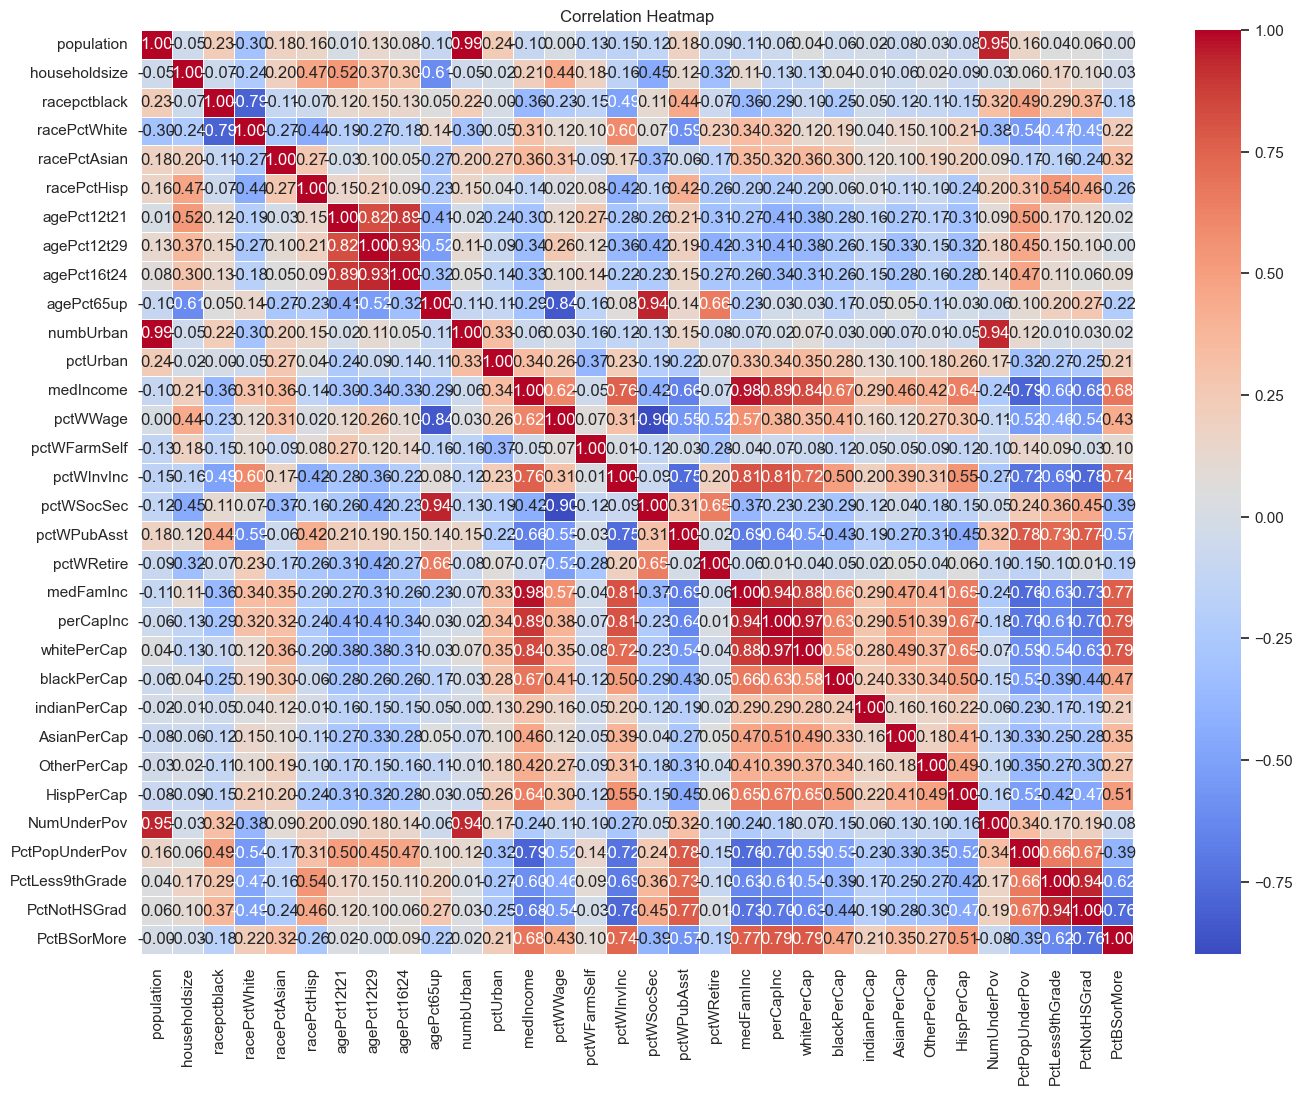

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

matrix = data_features.iloc[:,:32].corr()

plt.figure(figsize=(16,12))
sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [6]:
def select_uncorrelated_features(df, threshold=0.85):
    """
    Select features with a correlation below the input threshold.
    
    Args:
        df (pd.DataFrame): DataFrame with the features to evaluate.
        threshold (float in [0,1]): 
        
    Returns:
        to_keep (list) : list of features with a correlation coefficient below the threshold.
    """
    # Compute the correlation matrix
    corr_matrix = df.corr().abs()
    
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identify features with a correlation coefficient above the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Features with a correlation coef. below given the threhold.
    to_keep = [column for column in df.columns if column not in to_drop]
    
    return to_keep

In [7]:
test=select_uncorrelated_features(data_features[X_features_crime+['S',y]])

In [8]:
data_features = data_features.fillna(data_features.median(numeric_only=True))

In [9]:
X_features_crime= data_features[test].drop(columns=['S','ViolentCrimesPerPop']).columns.to_list()

In [10]:
crime_data = data_features.iloc[:,:32]

In [11]:
models = ['y_pred_fair', 'y_input_reg', 'y_score_equipy', 'y_pred_riken', 'y_pred_bias']
metrics = ['r2', 'mae', 'rmse', 'unfairness_W2', 'unfairness_W1', 'ks_stat']
# # Dictionnary to store the results
# all_results = {}

#   
# t_results = {model: {metric: [] for metric in metrics} for model in models}
        

In [12]:
def run_experiment(data_name,y, S_variable, X_features,data, n_simulations):
    """
    Exécute une expérience en faisant varier un paramètre spécifique.
    
    Args:
        varying_param: Le nom du paramètre à faire varier ('t_values', 'p_mu_bias', ou 'p_sigma_bias')
        param_values: Liste des valeurs pour le paramètre variable
        fixed_params: Dictionnaire des paramètres fixes
    
    Returns:
        all_results: Dictionnaire contenant les résultats pour chaque valeur du paramètre
    """
    # Liste des modèles et métriques
    models = ['y_pred_fair', 'y_input_reg', 'y_score_equipy', 'y_pred_riken', 'y_pred_bias','y_unaware']
    metrics = ['r2', 'GWR2','mae', 'rmse', 'unfairness_W2', 'unfairness_W1', 'ks_stat', 
               'indirect_mean_bias', 'indirect_structural_bias', 'interaction', 'direct_mean_bias',
                'beta_0_NoStd','beta_NoStd','gamma_NoStd',
                'fair_intercept_1_NoStd', 'fair_intercept_2_NoStd', 'beta_1_NoStd','beta_2_NoStd', 
                'unfairness_computed']
    param_riken_null=0

    # Dictionnaire pour stocker tous les résultats
    all_results = {}

    #Paramètre pour Exponentiated Gradient
    constraint="DP"
    loss="square"
    eps=0.05
    init_cache=[]

    # Boucle sur chaque valeur du paramètre variable
    t_results = {model: {metric: [] for metric in metrics} for model in models}
        
    # Effectuer n_simulations pour cette valeur du paramètre
    for bootstrap in tqdm(range(n_simulations)):

            # Préparation des données
        train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=bootstrap)
        train_dataset,pool_dataset = train_test_split(train_dataset, test_size=0.2, random_state=bootstrap)
        
        train_dataset, test_dataset,pool_dataset= train_dataset.copy(), test_dataset.copy(), pool_dataset.copy()
        for s in data[S_variable].unique():
            print(len(train_dataset[train_dataset[S_variable]==s]//3), 12*len(X_features))
            if len(train_dataset[train_dataset[S_variable]==s]//3) < 12*len(X_features):
                print(f'normalized_beta_{s}__and__norm_beta_{s}__are_set_to_0')
                param_riken_null +=1
            print(len(train_dataset[train_dataset[S_variable]==s]//2),18*len(X_features))
            if len(train_dataset[train_dataset[S_variable]==s]//2) < 18*len(X_features):
                print(f'beta_{s}_bis__is_set_to_0')
                param_riken_null +=1

        y_sensitive_feature = pd.DataFrame({f"{S_variable}": test_dataset[S_variable].to_list()})
        unique_groups = test_dataset[S_variable].unique()
        
        coef_unaware, param_dict_unaware, reg_unaware= Fair_model.input_linear_regression(train_dataset, test_dataset, 
                                S_variable, X_features, y, 
                                {}, False,
                                True, False, True)
        
        # Modèle Fair Linear
        coef_input_model, param_dictionnary, input_model, test_dataset = Fair_model.predict_fair_linear_score(
                train_dataset, pool_dataset, test_dataset, S_variable, y, X_features, True, False, True
            )
        
        t_results['y_input_reg']['beta_0_NoStd'].append(param_dictionnary['beta_0'])
        t_results['y_input_reg']['beta_NoStd'].append(param_dictionnary['beta'])
        t_results['y_input_reg']['gamma_NoStd'].append(param_dictionnary['gamma'])
            
        t_results['y_input_reg']['interaction'].append(param_dictionnary['interaction'])
        t_results['y_input_reg']['direct_mean_bias'].append(param_dictionnary['direct_mean_bias'])
        t_results['y_input_reg']['indirect_structural_bias'].append(param_dictionnary['indirect_structural_bias'])
        t_results['y_input_reg']['indirect_mean_bias'].append(param_dictionnary['indirect_mean_bias'])
        t_results['y_input_reg']['unfairness_computed'].append(param_dictionnary['unfairness_input_model'])

        t_results['y_pred_fair']['indirect_structural_bias'].append(param_dictionnary['indirect_structural_bias_fair_model'])
        t_results['y_pred_fair']['indirect_mean_bias'].append(param_dictionnary['indirect_mean_bias_fair_model'])
        t_results['y_pred_fair']['unfairness_computed'].append(param_dictionnary['unfairness_our_model'])
        
        t_results['y_pred_fair']['fair_intercept_1_NoStd'].append(param_dictionnary['fair_intercept']-param_dictionnary['invariant_var_cov_term']*np.dot(param_dictionnary['empirical_mean_-1'],param_dictionnary['beta'])/param_dictionnary['var_cov_product_-1'])
        t_results['y_pred_fair']['fair_intercept_2_NoStd'].append(param_dictionnary['fair_intercept']-param_dictionnary['invariant_var_cov_term']*np.dot(param_dictionnary['empirical_mean_1'],param_dictionnary['beta'])/param_dictionnary['var_cov_product_1'])
        t_results['y_pred_fair']['beta_1_NoStd'].append(param_dictionnary['invariant_var_cov_term']*param_dictionnary['beta']/param_dictionnary['var_cov_product_-1'])
        t_results['y_pred_fair']['beta_2_NoStd'].append(param_dictionnary['invariant_var_cov_term']*param_dictionnary['beta']/param_dictionnary['var_cov_product_1'])
        t_results['y_pred_fair']['gamma_NoStd'].append(0)
  
        
        # Modèle EquiPy
        Benchmark_model.benchmark_equipy(train_dataset, test_dataset, 'y_input_reg', S_variable)
            
        # Modèle Riken
        dictionnary_riken_raw = Benchmark_model.riken_prediction(train_dataset, test_dataset, S_variable, X_features, y)
            
        # Modèle Evgeni (model_bias)
        Benchmark_model.weighted_group_intercepts(train_dataset, test_dataset, X_features, y, S_variable, True)
            
            # Calculer et stocker les métriques pour chaque modèle
        for prediction in models:
            t_results[prediction]['r2'].append(r2_score(test_dataset[y], test_dataset[prediction]))
            t_results[prediction]['GWR2'].append(Metrics.group_weighted_r2(test_dataset,y,prediction,S_variable))
            t_results[prediction]['rmse'].append(np.sqrt(Metrics.mean_squared_error(test_dataset[y], test_dataset[prediction])))
            t_results[prediction]['unfairness_W1'].append(unfairness(np.array(test_dataset[prediction].tolist()), y_sensitive_feature))
            t_results[prediction]['unfairness_W2'].append(Metrics.unfairness_computation(prediction, S_variable, test_dataset))
                
            
            if len(unique_groups) >= 2:
                    ks_stat = kstest(
                        rvs=test_dataset[test_dataset[S_variable] == unique_groups[0]][prediction],
                        cdf=test_dataset[test_dataset[S_variable] == unique_groups[1]][prediction],
                        alternative='two-sided'
                    ).statistic
                    t_results[prediction]['ks_stat'].append(ks_stat)
        
        # Calculer les moyennes pour cette valeur du paramètre
    summary_t = {}
    for model in models:
        summary_t[model] = {}
        for metric in metrics:
            if t_results[model][metric]:  # Vérifier si la liste n'est pas vide
                summary_t[model][f'{metric}_mean'] = round(np.mean(t_results[model][metric]), 5)
                summary_t[model][f'{metric}_std'] = round(np.std(t_results[model][metric]), 5)
            else:
                summary_t[model][f'{metric}_mean'] = None
                summary_t[model][f'{metric}_std'] = None
    
    return summary_t, t_results


In [13]:
summary_crime,crime_results= run_experiment('CRIME_GRW2_Y_corrected',y, S_variable_crime,X_features_crime,data_features,50)

  0%|          | 0/50 [00:00<?, ?it/s]

642 312
642 468
634 312
634 468


  2%|▏         | 1/50 [00:02<01:53,  2.31s/it]

633 312
633 468
643 312
643 468


  4%|▍         | 2/50 [00:03<01:22,  1.72s/it]

657 312
657 468
619 312
619 468


  6%|▌         | 3/50 [00:04<01:06,  1.41s/it]

659 312
659 468
617 312
617 468


  8%|▊         | 4/50 [00:06<01:06,  1.44s/it]

642 312
642 468
634 312
634 468


 10%|█         | 5/50 [00:08<01:12,  1.61s/it]

669 312
669 468
607 312
607 468


 12%|█▏        | 6/50 [00:09<01:11,  1.63s/it]

640 312
640 468
636 312
636 468


 14%|█▍        | 7/50 [00:11<01:05,  1.52s/it]

643 312
643 468
633 312
633 468


 16%|█▌        | 8/50 [00:12<00:59,  1.42s/it]

672 312
672 468
604 312
604 468


 18%|█▊        | 9/50 [00:14<01:03,  1.55s/it]

669 312
669 468
607 312
607 468


 20%|██        | 10/50 [00:16<01:13,  1.84s/it]

658 312
658 468
618 312
618 468


 22%|██▏       | 11/50 [00:17<01:05,  1.67s/it]

663 312
663 468
613 312
613 468


 24%|██▍       | 12/50 [00:19<00:59,  1.57s/it]

636 312
636 468
640 312
640 468


 26%|██▌       | 13/50 [00:21<01:03,  1.72s/it]

656 312
656 468
620 312
620 468


 28%|██▊       | 14/50 [00:23<01:05,  1.81s/it]

650 312
650 468
626 312
626 468


 30%|███       | 15/50 [00:25<01:07,  1.92s/it]

673 312
673 468
603 312
603 468


 32%|███▏      | 16/50 [00:27<01:07,  1.99s/it]

664 312
664 468
612 312
612 468


 34%|███▍      | 17/50 [00:30<01:11,  2.17s/it]

651 312
651 468
625 312
625 468


 36%|███▌      | 18/50 [00:32<01:08,  2.15s/it]

643 312
643 468
633 312
633 468


 38%|███▊      | 19/50 [00:34<01:10,  2.26s/it]

654 312
654 468
622 312
622 468


 40%|████      | 20/50 [00:36<01:01,  2.07s/it]

653 312
653 468
623 312
623 468


 42%|████▏     | 21/50 [00:38<00:58,  2.02s/it]

652 312
652 468
624 312
624 468


 44%|████▍     | 22/50 [00:40<01:00,  2.15s/it]

644 312
644 468
632 312
632 468


 46%|████▌     | 23/50 [00:41<00:49,  1.85s/it]

674 312
674 468
602 312
602 468


 48%|████▊     | 24/50 [00:43<00:42,  1.63s/it]

666 312
666 468
610 312
610 468


 50%|█████     | 25/50 [00:44<00:39,  1.57s/it]

660 312
660 468
616 312
616 468


 52%|█████▏    | 26/50 [00:45<00:36,  1.53s/it]

646 312
646 468
630 312
630 468


 54%|█████▍    | 27/50 [00:47<00:32,  1.40s/it]

659 312
659 468
617 312
617 468


 56%|█████▌    | 28/50 [00:48<00:28,  1.30s/it]

662 312
662 468
614 312
614 468


 58%|█████▊    | 29/50 [00:49<00:25,  1.23s/it]

647 312
647 468
629 312
629 468


 60%|██████    | 30/50 [00:50<00:23,  1.18s/it]

643 312
643 468
633 312
633 468


 62%|██████▏   | 31/50 [00:51<00:22,  1.18s/it]

665 312
665 468
611 312
611 468


 64%|██████▍   | 32/50 [00:52<00:21,  1.21s/it]

651 312
651 468
625 312
625 468


 66%|██████▌   | 33/50 [00:54<00:23,  1.37s/it]

665 312
665 468
611 312
611 468


 68%|██████▊   | 34/50 [00:55<00:22,  1.39s/it]

670 312
670 468
606 312
606 468


 70%|███████   | 35/50 [00:57<00:19,  1.33s/it]

641 312
641 468
635 312
635 468


 72%|███████▏  | 36/50 [00:58<00:17,  1.25s/it]

661 312
661 468
615 312
615 468


 74%|███████▍  | 37/50 [00:59<00:15,  1.20s/it]

649 312
649 468
627 312
627 468


 76%|███████▌  | 38/50 [01:00<00:14,  1.18s/it]

648 312
648 468
628 312
628 468


 78%|███████▊  | 39/50 [01:01<00:12,  1.15s/it]

674 312
674 468
602 312
602 468


 80%|████████  | 40/50 [01:02<00:10,  1.10s/it]

671 312
671 468
605 312
605 468


 82%|████████▏ | 41/50 [01:03<00:11,  1.23s/it]

646 312
646 468
630 312
630 468


 84%|████████▍ | 42/50 [01:05<00:10,  1.37s/it]

652 312
652 468
624 312
624 468


 86%|████████▌ | 43/50 [01:06<00:09,  1.37s/it]

664 312
664 468
612 312
612 468


 88%|████████▊ | 44/50 [01:08<00:07,  1.28s/it]

665 312
665 468
611 312
611 468


 90%|█████████ | 45/50 [01:09<00:05,  1.19s/it]

649 312
649 468
627 312
627 468


 92%|█████████▏| 46/50 [01:10<00:04,  1.18s/it]

658 312
658 468
618 312
618 468


 94%|█████████▍| 47/50 [01:11<00:03,  1.18s/it]

638 312
638 468
638 312
638 468


 96%|█████████▌| 48/50 [01:12<00:02,  1.26s/it]

642 312
642 468
634 312
634 468


 98%|█████████▊| 49/50 [01:14<00:01,  1.26s/it]

648 312
648 468
628 312
628 468


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


In [31]:
keys_to_display = ['GWR2_mean', 'GWR2_std', 'rmse_mean', 'rmse_std', 'ks_stat_mean', 'ks_stat_std']
filtered_results = {k: summary_crime['y_pred_riken'][k] for k in keys_to_display}

print(filtered_results)

{'GWR2_mean': np.float64(0.34961), 'GWR2_std': np.float64(0.09236), 'rmse_mean': np.float64(0.19146), 'rmse_std': np.float64(0.01021), 'ks_stat_mean': np.float64(0.20191), 'ks_stat_std': np.float64(0.04816)}


__Coefficients__

In [15]:
def plot_fair_coefficient_evolution_real_data(t_results, X_indices, name_figure, X_features, 
                                             selected_vars=None, explicit_names=None):
    """
    Plot the evolution of coefficients from input regression to fair model for real data,
    using colorblind-friendly colors and compact design.
    
    Parameters:
    -----------
    t_results : dict
        Dictionary containing regression results
    X_indices : list
        Indices of features to include in the plot
    name_figure : str
        Path to save the figure
    X_features : list
        Names of all features
    selected_vars : list, optional
        Indices of variables to display (relative to X_indices). If None, all variables are displayed.
    explicit_names : dict, optional
        Dictionary mapping original feature names to more explicit display names
    """
    # Reset style to default and set clean theme
    plt.style.use('default')
    sns.set_theme(style="whitegrid")
    sns.set_context("paper", font_scale=1.0)  # Reduced font scale
    
    # Utiliser la palette colorblind de seaborn
    palette = sns.color_palette("colorblind")
    
    # Définir les couleurs à partir de la palette colorblind
    base_color = "#F4F4F4"  # Gardons le gris clair pour la base
    increase_color = palette[2]  # Vert-bleu (généralement accessible)
    decrease_color = palette[1]  # Orange (généralement accessible)
    
    # Create smaller figure
    fig, ax1 = plt.subplots(figsize=(5, 2.5), dpi=300)  # Reduced size
    
    # Helper function to format variable names
    def _fmt(txt: str, width: int = 12) -> str:
        # Si un nom explicite est fourni, l'utiliser
        if explicit_names and txt in explicit_names:
            return explicit_names[txt]
        # Sinon, formater comme avant
        if "_" in txt:
            parts = txt.split("_")
            return "\n".join(parts)
        return txt
    
    # Prepare data structure for plotting
    raw_variables = ['Intercept'] + [f'{X_features[i]}' for i in X_indices] + ['S']
    
    # Filter variables if selected_vars is provided
    if selected_vars is not None:
        # Always include intercept (index 0) and S (last index)
        display_indices = [0] + [i+1 for i in selected_vars] + [len(raw_variables)-1]
        raw_variables = [raw_variables[i] for i in display_indices]
        # Adjust X_indices for coefficient extraction
        selected_X_indices = [X_indices[i] for i in selected_vars]
    else:
        display_indices = list(range(len(raw_variables)))
        selected_X_indices = X_indices
    
    # Format variable names for display
    variables = [_fmt(var) for var in raw_variables]
    n_vars = len(variables)
    
 # Extract coefficients
    # Group 1 base coefficients (input regression)
    base_g1 = [t_results['y_input_reg']['beta_0_NoStd'][0]]  # Intercept
    if selected_vars is not None:
        base_g1.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in selected_X_indices])  # Selected Features
    else:
        base_g1.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in X_indices])  # All Features
    base_g1.append(t_results['y_input_reg']['gamma_NoStd'][0])  # S feature
    base_g1 = np.array(base_g1)
    
    # Group 2 base coefficients (input regression)
    base_g2 = [t_results['y_input_reg']['beta_0_NoStd'][0]]  # Intercept
    if selected_vars is not None:
        base_g2.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in selected_X_indices])  # Selected Features
    else:
        base_g2.extend([t_results['y_input_reg']['beta_NoStd'][0][i] for i in X_indices])  # All Features
    base_g2.append(t_results['y_input_reg']['gamma_NoStd'][0])  # S feature
    base_g2 = np.array(base_g2)
    
    # Group 1 fair coefficients
    fair_g1 = [t_results['y_pred_fair']['fair_intercept_1_NoStd'][0]]  # Intercept
    if selected_vars is not None:
        fair_g1.extend([t_results['y_pred_fair']['beta_1_NoStd'][0][i] for i in selected_X_indices])  # Selected Features
    else:
        fair_g1.extend([t_results['y_pred_fair']['beta_1_NoStd'][0][i] for i in X_indices])  # All Features
    fair_g1.append(t_results['y_pred_fair']['gamma_NoStd'][0])  # S feature
    fair_g1 = np.array(fair_g1)
    
    # Group 2 fair coefficients
    fair_g2 = [t_results['y_pred_fair']['fair_intercept_2_NoStd'][0]]  # Intercept
    if selected_vars is not None:
        fair_g2.extend([t_results['y_pred_fair']['beta_2_NoStd'][0][i] for i in selected_X_indices])  # Selected Features
    else:
        fair_g2.extend([t_results['y_pred_fair']['beta_2_NoStd'][0][i] for i in X_indices])  # All Features
    fair_g2.append(t_results['y_pred_fair']['gamma_NoStd'][0])  # S feature
    fair_g2 = np.array(fair_g2)
    
    # Calculate differences
    diff_g1 = fair_g1 - base_g1
    diff_g2 = fair_g2 - base_g2
    
    # Bar placement
    width = 0.3  # Reduced width
    x = np.arange(n_vars)
    offset = [-width / 2, width / 2]
    
    # Plot bars for each group
    groups = ["Group 1", "Group 2"]
    bases = [base_g1, base_g2]
    diffs = [diff_g1, diff_g2]
    
    for gi, group in enumerate(groups):
        xg_all = x + offset[gi]
        
        # Base bars (input regression)
        ax1.bar(xg_all, bases[gi], width,
               color=base_color, edgecolor="#222B36", lw=0.4,
               label=f"Input Reg ({group})" if gi == 0 else None, zorder=2)
        
        # Difference bars (to fair model) - Correction pour éviter l'erreur de broadcast
        # Créer un tableau de couleurs de la même taille que diffs[gi]
        bar_colors = []
        for d in diffs[gi]:
            if d > 0:
                bar_colors.append(increase_color)
            else:
                bar_colors.append(decrease_color)
        
        ax1.bar(xg_all, diffs[gi], width, bottom=bases[gi],
               color=bar_colors,
               edgecolor="#222B36", lw=0.4,
               label=f"Δ to Fair Model" if gi == 0 else None, zorder=3)
        
        # Arrows showing direction of change - only for significant changes
        for vi, (b, d) in enumerate(zip(bases[gi], diffs[gi])):
            if abs(d) < 1e-10 or abs(d) < abs(b)*0.05:  # Skip if no significant change
                continue
            x_c = xg_all[vi]
            y_start = b + (0.05 * d)  # Start 5% from base
            y_end = b + (0.95 * d)    # End 95% toward fair value
            ax1.annotate("",
                        xy=(x_c, y_end), xytext=(x_c, y_start),
                        arrowprops=dict(arrowstyle="->",
                                        color="#000000",
                                        lw=0.8),  # Thinner arrows
                        zorder=6)
    
    # X-axis labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(variables, rotation=0, ha='center', fontsize=8)  # Smaller font
    
    # Make sure y-axis tick labels are also consistent
    ax1.tick_params(axis='y', labelsize=8)  # Smaller font
    
    # Title and labels
    ax1.set_ylabel("Coefficient Value", fontsize=9)
    ax1.set_xlabel(" ", fontsize=0)
    
    # Zero line
    ax1.axhline(0, color="#222B36", lw=0.5)
    
    # Create a compact legend
    # Create custom legend elements
    legend_elements = [
        # Group identification
        Line2D([0], [0], marker='s', color='w', markerfacecolor='none', markeredgecolor='#222B36', 
              markersize=8, label="Group 1 (left)"),
        Line2D([0], [0], marker='s', color='w', markerfacecolor='none', markeredgecolor='#222B36', 
              markersize=8, label="Group 2 (right)"),
        # Color coding
        Line2D([0], [0], marker='s', color='w', markerfacecolor=base_color, markeredgecolor='#222B36', 
              markersize=8, label='Input Reg.'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor=increase_color, markeredgecolor='#222B36', 
              markersize=8, label='Increase'),
        Line2D([0], [0], marker='s', color='w', markerfacecolor=decrease_color, markeredgecolor='#222B36', 
              markersize=8, label='Decrease')
    ]
    
    # Place legend at the top of the figure
    fig.legend(handles=legend_elements, loc='upper center', 
              bbox_to_anchor=(0.5, 1.05), ncol=5, frameon=False, 
              fontsize=7, handletextpad=0.5, columnspacing=1.0)
    
    plt.tight_layout()
    
    # Save the figure
    plt.savefig(name_figure, bbox_inches='tight', dpi=300)
    
    return fig



In [16]:
# Définir des noms plus explicites pour les variables
explicit_names = {
    'population':'Population',
    'pctWInvInc': 'Households \n with investment \n income', #\nIncome %',
    'pctWPubAsst': 'Households \n with public \n assistance income',
    'Intercept': 'Intercept',
    'S': 'Sensitive\nAttribute'
}

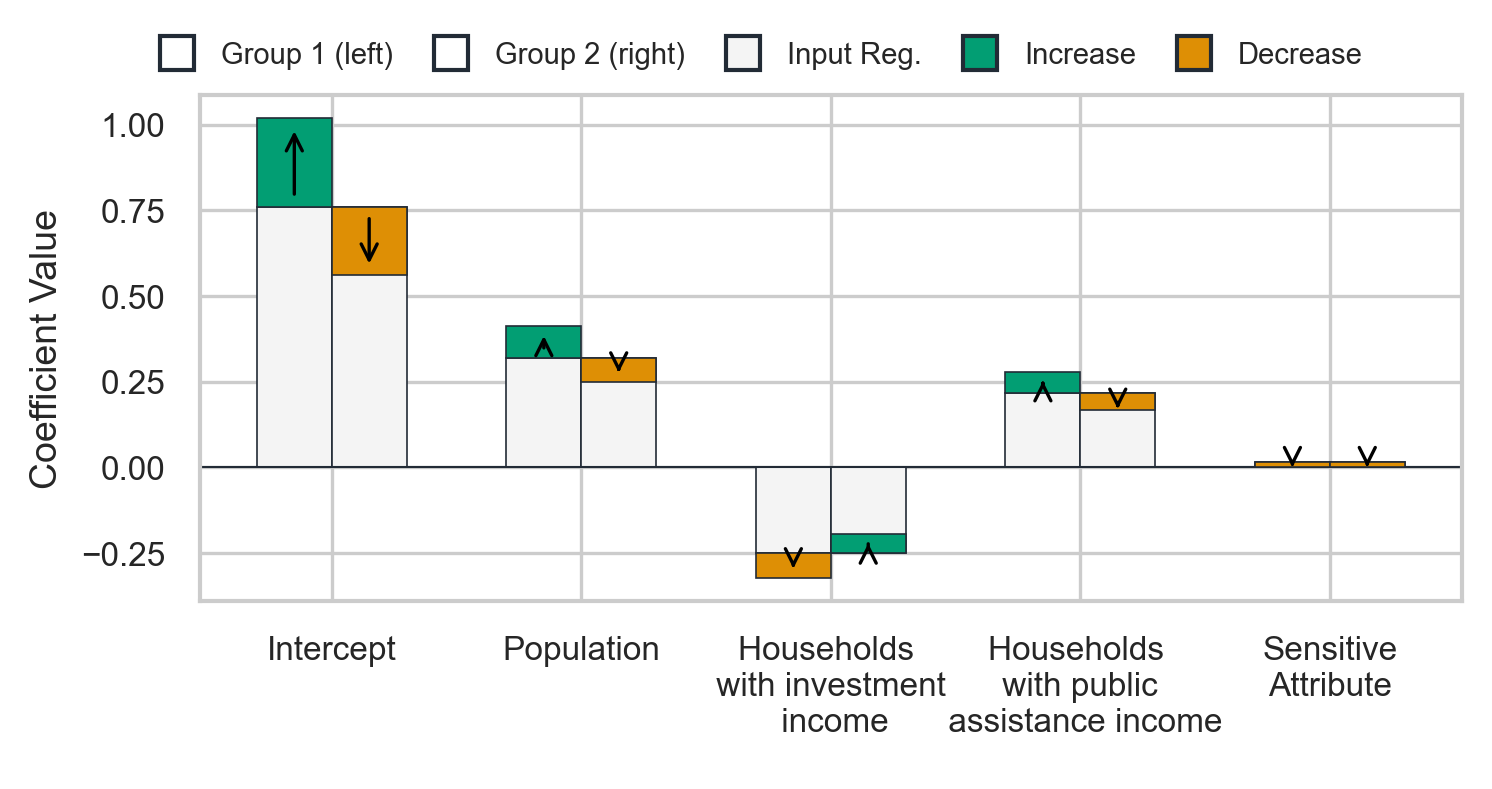

In [17]:
# Appeler la fonction avec les noms explicites
plot_crime_coef = plot_fair_coefficient_evolution_real_data(crime_results, [0, 12, 13], 'Coef Crime', X_features_crime, 
                                         explicit_names=explicit_names)


__Sauvegarde des résultats__

In [18]:
# import pickle
# import os
# # Chemin de sauvegarde (attention à bien utiliser les backslashes doubles ou une chaîne brute)
# chemin_fichier = r"C:\\Users\\bertille.tierny\\Transparence - Fairness\\Linear model under DP\\AAAI figures and code\\figures\\CRIME_results.pkl"

# # Sauvegarde du dictionnaire dans le fichier
# with open(chemin_fichier, "wb") as fichier:
#     pickle.dump(summary_crime, fichier)


# # Pour le recharger (exemple)
# with open(chemin_fichier, "rb") as fichier:
#     dict_recharge = pickle.load(fichier)

# print(dict_recharge)


## __Law dataset__

In [19]:
def select_uncorrelated_features(df, threshold=0.8):
    """
    Sélectionne les variables qui ne sont pas fortement corrélées entre elles.
    
    Args:
        df: DataFrame contenant les variables
        threshold: Seuil de corrélation (défaut: 0.8)
        
    Returns:
        Liste des noms de variables à conserver
    """
    # Calculer la matrice de corrélation
    corr_matrix = df.corr().abs()
    
    # Créer une matrice triangulaire supérieure
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identifier les colonnes à supprimer (corrélées au-dessus du seuil)
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Colonnes à conserver
    to_keep = [column for column in df.columns if column not in to_drop]
    
    return to_keep

In [20]:
data_law = pd.read_csv("bar_pass_prediction.csv")

In [21]:
data_law.fillna(value=0, inplace=True)

In [22]:
S_variable = 'race1'
data_law.loc[data_law["race1"] != "white", "race1"] =-1
data_law.loc[data_law["race1"] == "white", "race1"] = 1
data_law['race1'].value_counts()

race1
1     18716
-1     3691
Name: count, dtype: int64

Variables 
-  Law School Admission Test  : LSAT
-  undergraduate grade-point average (UGPA)
- cluster : The other method of grouping law schools was based on the
application of a statistical method known as cluster analysis.' Law schools were assigned to clusters basedon simultaneous consideration of seven variables. Four of the variables (size, cost, selectivity, and faculty / student ratio) focus on characteristics of the school, while the other three (percent minority, median LSAT score, and median UGPA) focus on characteristics of the student body. The cluster analysis identified six naturally occurring clusters or groups of law schools, numbered 1 to 6.2


In [23]:
data_law_selected = data_law.drop(columns=['race1','gpa','ugpa','ID', 'sex','male','race', 'other','asian','black','hisp','dnn_bar_pass_prediction'], inplace=False)
X_features = select_uncorrelated_features(data_law_selected.select_dtypes(exclude='object'), threshold=0.8)
y='gpa'

In [24]:
X_features

['decile1b',
 'cluster',
 'lsat',
 'DOB_yr',
 'bar1_yr',
 'bar2_yr',
 'fulltime',
 'fam_inc',
 'pass_bar',
 'tier']

In [25]:
train_set, test_set = train_test_split(data_law, test_size=0.25)
train_set, pool_set = train_test_split(data_law, test_size=0.25)

In [26]:
summary_t,t_results= run_experiment('LAW_GRW2',y, S_variable,X_features,data_law[X_features+[y,S_variable]],50)

  0%|          | 0/50 [00:00<?, ?it/s]

11925 120
11925 180
2415 120
2415 180


  2%|▏         | 1/50 [00:08<07:01,  8.60s/it]

11927 120
11927 180
2413 120
2413 180


  4%|▍         | 2/50 [00:15<06:02,  7.54s/it]

11974 120
11974 180
2366 120
2366 180


  6%|▌         | 3/50 [00:22<05:54,  7.55s/it]

12018 120
12018 180
2322 120
2322 180


  8%|▊         | 4/50 [00:30<05:46,  7.54s/it]

11983 120
11983 180
2357 120
2357 180


 10%|█         | 5/50 [00:46<07:57, 10.61s/it]

11989 120
11989 180
2351 120
2351 180


 12%|█▏        | 6/50 [00:53<06:54,  9.43s/it]

11950 120
11950 180
2390 120
2390 180


 14%|█▍        | 7/50 [00:58<05:35,  7.79s/it]

11968 120
11968 180
2372 120
2372 180


 16%|█▌        | 8/50 [01:02<04:36,  6.59s/it]

11983 120
11983 180
2357 120
2357 180


 18%|█▊        | 9/50 [01:05<03:54,  5.72s/it]

11996 120
11996 180
2344 120
2344 180


 20%|██        | 10/50 [01:09<03:27,  5.19s/it]

11977 120
11977 180
2363 120
2363 180


 22%|██▏       | 11/50 [01:13<03:04,  4.72s/it]

11982 120
11982 180
2358 120
2358 180


 24%|██▍       | 12/50 [01:17<02:49,  4.46s/it]

11963 120
11963 180
2377 120
2377 180


 26%|██▌       | 13/50 [01:21<02:39,  4.31s/it]

11982 120
11982 180
2358 120
2358 180


 28%|██▊       | 14/50 [01:25<02:28,  4.12s/it]

11973 120
11973 180
2367 120
2367 180


 30%|███       | 15/50 [01:29<02:24,  4.13s/it]

11986 120
11986 180
2354 120
2354 180


 32%|███▏      | 16/50 [01:32<02:15,  3.99s/it]

11961 120
11961 180
2379 120
2379 180


 34%|███▍      | 17/50 [01:36<02:11,  3.98s/it]

12001 120
12001 180
2339 120
2339 180


 36%|███▌      | 18/50 [01:40<02:08,  4.03s/it]

11950 120
11950 180
2390 120
2390 180


 38%|███▊      | 19/50 [01:45<02:07,  4.11s/it]

11964 120
11964 180
2376 120
2376 180


 40%|████      | 20/50 [01:49<02:01,  4.04s/it]

12014 120
12014 180
2326 120
2326 180


 42%|████▏     | 21/50 [01:52<01:54,  3.93s/it]

11983 120
11983 180
2357 120
2357 180


 44%|████▍     | 22/50 [01:56<01:47,  3.85s/it]

11918 120
11918 180
2422 120
2422 180


 46%|████▌     | 23/50 [02:00<01:44,  3.85s/it]

12036 120
12036 180
2304 120
2304 180


 48%|████▊     | 24/50 [02:04<01:41,  3.89s/it]

11962 120
11962 180
2378 120
2378 180


 50%|█████     | 25/50 [02:09<01:47,  4.30s/it]

11961 120
11961 180
2379 120
2379 180


 52%|█████▏    | 26/50 [02:15<01:51,  4.64s/it]

11975 120
11975 180
2365 120
2365 180


 54%|█████▍    | 27/50 [02:34<03:26,  8.96s/it]

11957 120
11957 180
2383 120
2383 180


 56%|█████▌    | 28/50 [02:43<03:19,  9.08s/it]

11985 120
11985 180
2355 120
2355 180


 58%|█████▊    | 29/50 [02:50<02:56,  8.41s/it]

11970 120
11970 180
2370 120
2370 180


 60%|██████    | 30/50 [02:57<02:39,  7.95s/it]

11981 120
11981 180
2359 120
2359 180


 62%|██████▏   | 31/50 [03:05<02:34,  8.14s/it]

12001 120
12001 180
2339 120
2339 180


 64%|██████▍   | 32/50 [03:23<03:21, 11.17s/it]

11921 120
11921 180
2419 120
2419 180


 66%|██████▌   | 33/50 [03:39<03:31, 12.46s/it]

11946 120
11946 180
2394 120
2394 180


 68%|██████▊   | 34/50 [03:46<02:53, 10.81s/it]

12005 120
12005 180
2335 120
2335 180


 70%|███████   | 35/50 [03:52<02:18,  9.26s/it]

11997 120
11997 180
2343 120
2343 180


 72%|███████▏  | 36/50 [03:57<01:52,  8.01s/it]

11980 120
11980 180
2360 120
2360 180


 74%|███████▍  | 37/50 [04:03<01:36,  7.39s/it]

11959 120
11959 180
2381 120
2381 180


 76%|███████▌  | 38/50 [04:10<01:30,  7.52s/it]

11999 120
11999 180
2341 120
2341 180


 78%|███████▊  | 39/50 [04:16<01:17,  7.07s/it]

11973 120
11973 180
2367 120
2367 180


 80%|████████  | 40/50 [04:22<01:04,  6.49s/it]

11952 120
11952 180
2388 120
2388 180


 82%|████████▏ | 41/50 [04:29<00:59,  6.66s/it]

11985 120
11985 180
2355 120
2355 180


 84%|████████▍ | 42/50 [04:39<01:02,  7.82s/it]

11924 120
11924 180
2416 120
2416 180


 86%|████████▌ | 43/50 [04:50<01:01,  8.74s/it]

12014 120
12014 180
2326 120
2326 180


 88%|████████▊ | 44/50 [05:04<01:00, 10.16s/it]

11957 120
11957 180
2383 120
2383 180


 90%|█████████ | 45/50 [05:11<00:46,  9.38s/it]

11965 120
11965 180
2375 120
2375 180


 92%|█████████▏| 46/50 [05:22<00:39,  9.96s/it]

11968 120
11968 180
2372 120
2372 180


 94%|█████████▍| 47/50 [05:32<00:29,  9.88s/it]

11961 120
11961 180
2379 120
2379 180


 96%|█████████▌| 48/50 [05:39<00:17,  8.94s/it]

12018 120
12018 180
2322 120
2322 180


 98%|█████████▊| 49/50 [05:46<00:08,  8.38s/it]

11991 120
11991 180
2349 120
2349 180


100%|██████████| 50/50 [05:52<00:00,  7.06s/it]


In [27]:
keys_to_display = ['GWR2_mean', 'GWR2_std', 'rmse_mean', 'rmse_std', 'ks_stat_mean', 'ks_stat_std']
filtered_results = {k: summary_t['y_score_equipy'][k] for k in keys_to_display}

print(filtered_results)

{'GWR2_mean': np.float64(0.15179), 'GWR2_std': np.float64(0.00893), 'rmse_mean': np.float64(0.37318), 'rmse_std': np.float64(0.00302), 'ks_stat_mean': np.float64(0.03967), 'ks_stat_std': np.float64(0.01156)}


__Save results__

In [28]:
# import pickle
# import os
# # Chemin de sauvegarde (attention à bien utiliser les backslashes doubles ou une chaîne brute)
# chemin_fichier = r"C:\\Users\\bertille.tierny\\Transparence - Fairness\\Linear model under DP\\AAAI figures and code\\figures\\LAW_results.pkl"

# # Sauvegarde du dictionnaire dans le fichier
# with open(chemin_fichier, "wb") as fichier:
#     pickle.dump(summary_t, fichier)


# # Pour le recharger (exemple)
# with open(chemin_fichier, "rb") as fichier:
#     dict_recharge = pickle.load(fichier)

# print(dict_recharge)


In [29]:
X_indices_law=[]
for i in range(len(X_features)):
    X_indices_law.append(i)

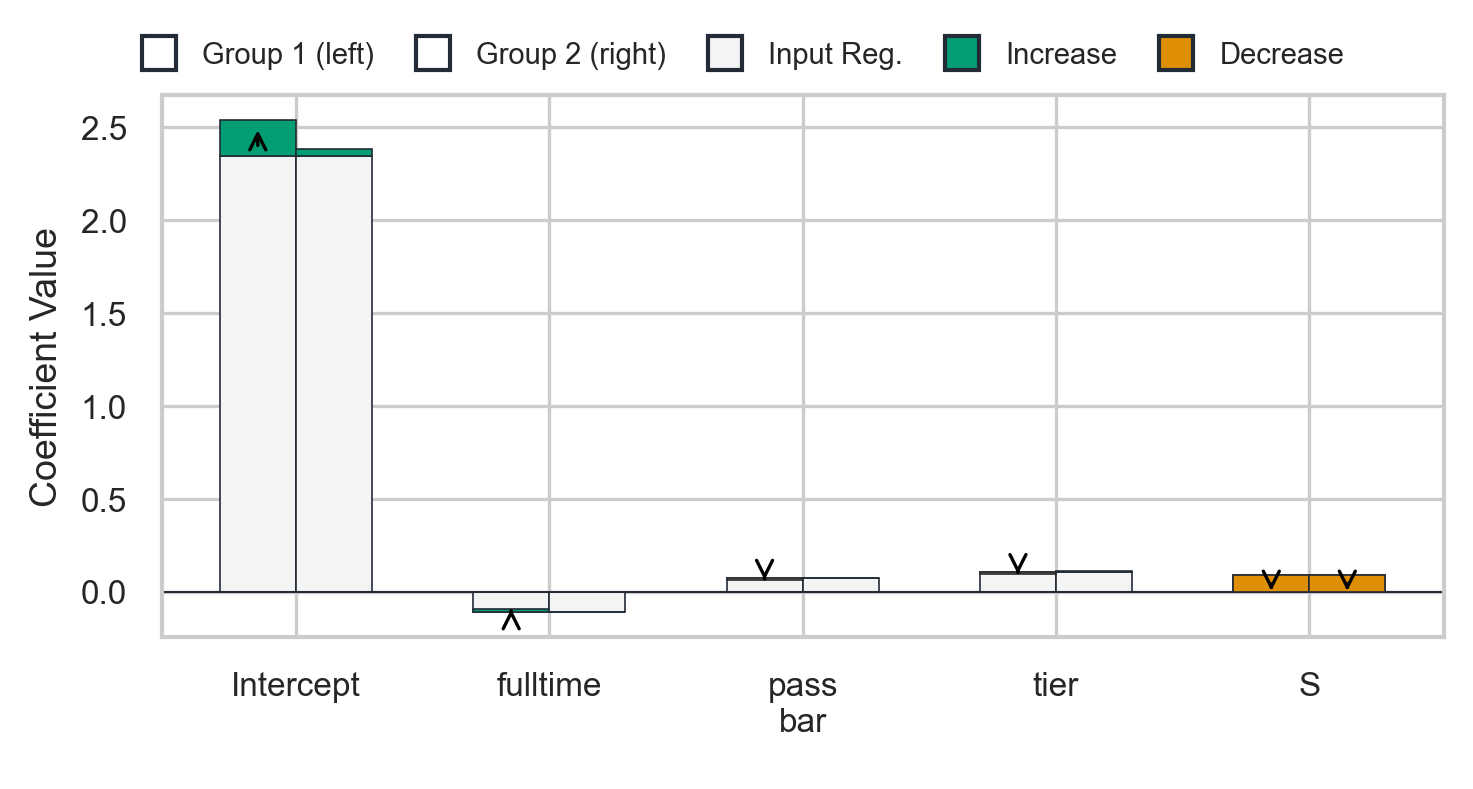

In [30]:
plot_law = plot_fair_coefficient_evolution_real_data(t_results, [6,8,9],'Plot coef Law', X_features)